# Forecast del índice Ibex35 utilizando Google trends

Vamos a analizar la serie temporal del índice bursátil Ibex35 utilizando como referencia búsquedas en google de ciertos términos relacionados como 
- crisis económica 
- Euribor 
- Inflación
- Prima de Riesgo 
- Covid

## Importaciones y configuración

In [1]:
from datetime import date, datetime
import os

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import yaml

plt.style.use("seaborn-v0_8")
matplotlib.rcParams['figure.figsize'] = (16, 6)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format='retina'

## Funciones auxiliares

In [2]:
config = yaml.safe_load(open("config.yml"))
data_path = os.path.join(
    config.get("working_dir"),
    config.get("data").get("raw_data")
)

# Funciones para cargar los datos 
def load_google_csv(filename: str):
    df = pd.read_csv(
        os.path.join(data_path, filename + ".csv"),
        names=["ds", filename],
        skiprows=3
    )
    if df[filename].dtype == "object":
        df[filename] = df[filename].str.replace("<", "").astype("float")
    df["ds"] = pd.to_datetime(df["ds"])
    df["year"] = df["ds"].dt.year
    df["yearweek"] = df["ds"].dt.isocalendar().week
    df = df.drop(columns="ds")
    df = df.set_index(["year", "yearweek"])
    return df

def load_ibex_csv():
    df = pd.read_csv(
        os.path.join(data_path, "ibex35.csv")
    )
    df = df[["Fecha", "Apertura"]].rename(columns={"Fecha": "ds", "Apertura": "ibex"})
    df["ds"] = pd.to_datetime(df["ds"], format="%d.%m.%Y")
    df["ibex"] = (df["ibex"]
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype("float")
    )
    df["year"] = df["ds"].dt.year
    df["yearweek"] = df["ds"].dt.isocalendar().week
    df = df.drop(columns="ds")
    df = df.groupby(["year", "yearweek"])[["ibex"]].mean()
    return df

def load_df():
    ibex = load_ibex_csv()
    google_crisis_economica = load_google_csv("google_crisis_economica")
    google_euribor = load_google_csv("google_euribor")
    google_inflacion = load_google_csv("google_inflacion")
    google_prima_de_riesgo = load_google_csv("google_prima_riesgo")
    google_covid = load_google_csv("google_covid")
    df = pd.concat(
        [ibex, google_crisis_economica, google_euribor, google_inflacion, google_prima_de_riesgo, google_covid],
         axis=1
    )
    df = df.dropna()
    return df

In [3]:
# Funciones auxiliares para pintar series

def plot_series(df, ax, title=None, plot_year=True):
    df["ibex"].plot(ax=ax, linewidth=4, linestyle="dashed", label="ibex")
    df.drop("ibex", axis=1).plot(ax=ax, alpha=0.6)
    if title:
        ax.set_title(title)
    ax.legend()

    if plot_year:
        df = df.sort_index()
        min_year = df.index.get_level_values("year").min()
        max_year = df.index.get_level_values("year").max()
        for year in range(min_year + 1, max_year + 1):
            plt.axvline(np.argmax(df.index >= (year, 0)), linestyle='--', color='k', alpha=0.5)

## Carga de datos

In [4]:
df = load_df()

Para representar los datos vamos a cambiar la escala de `ibex`

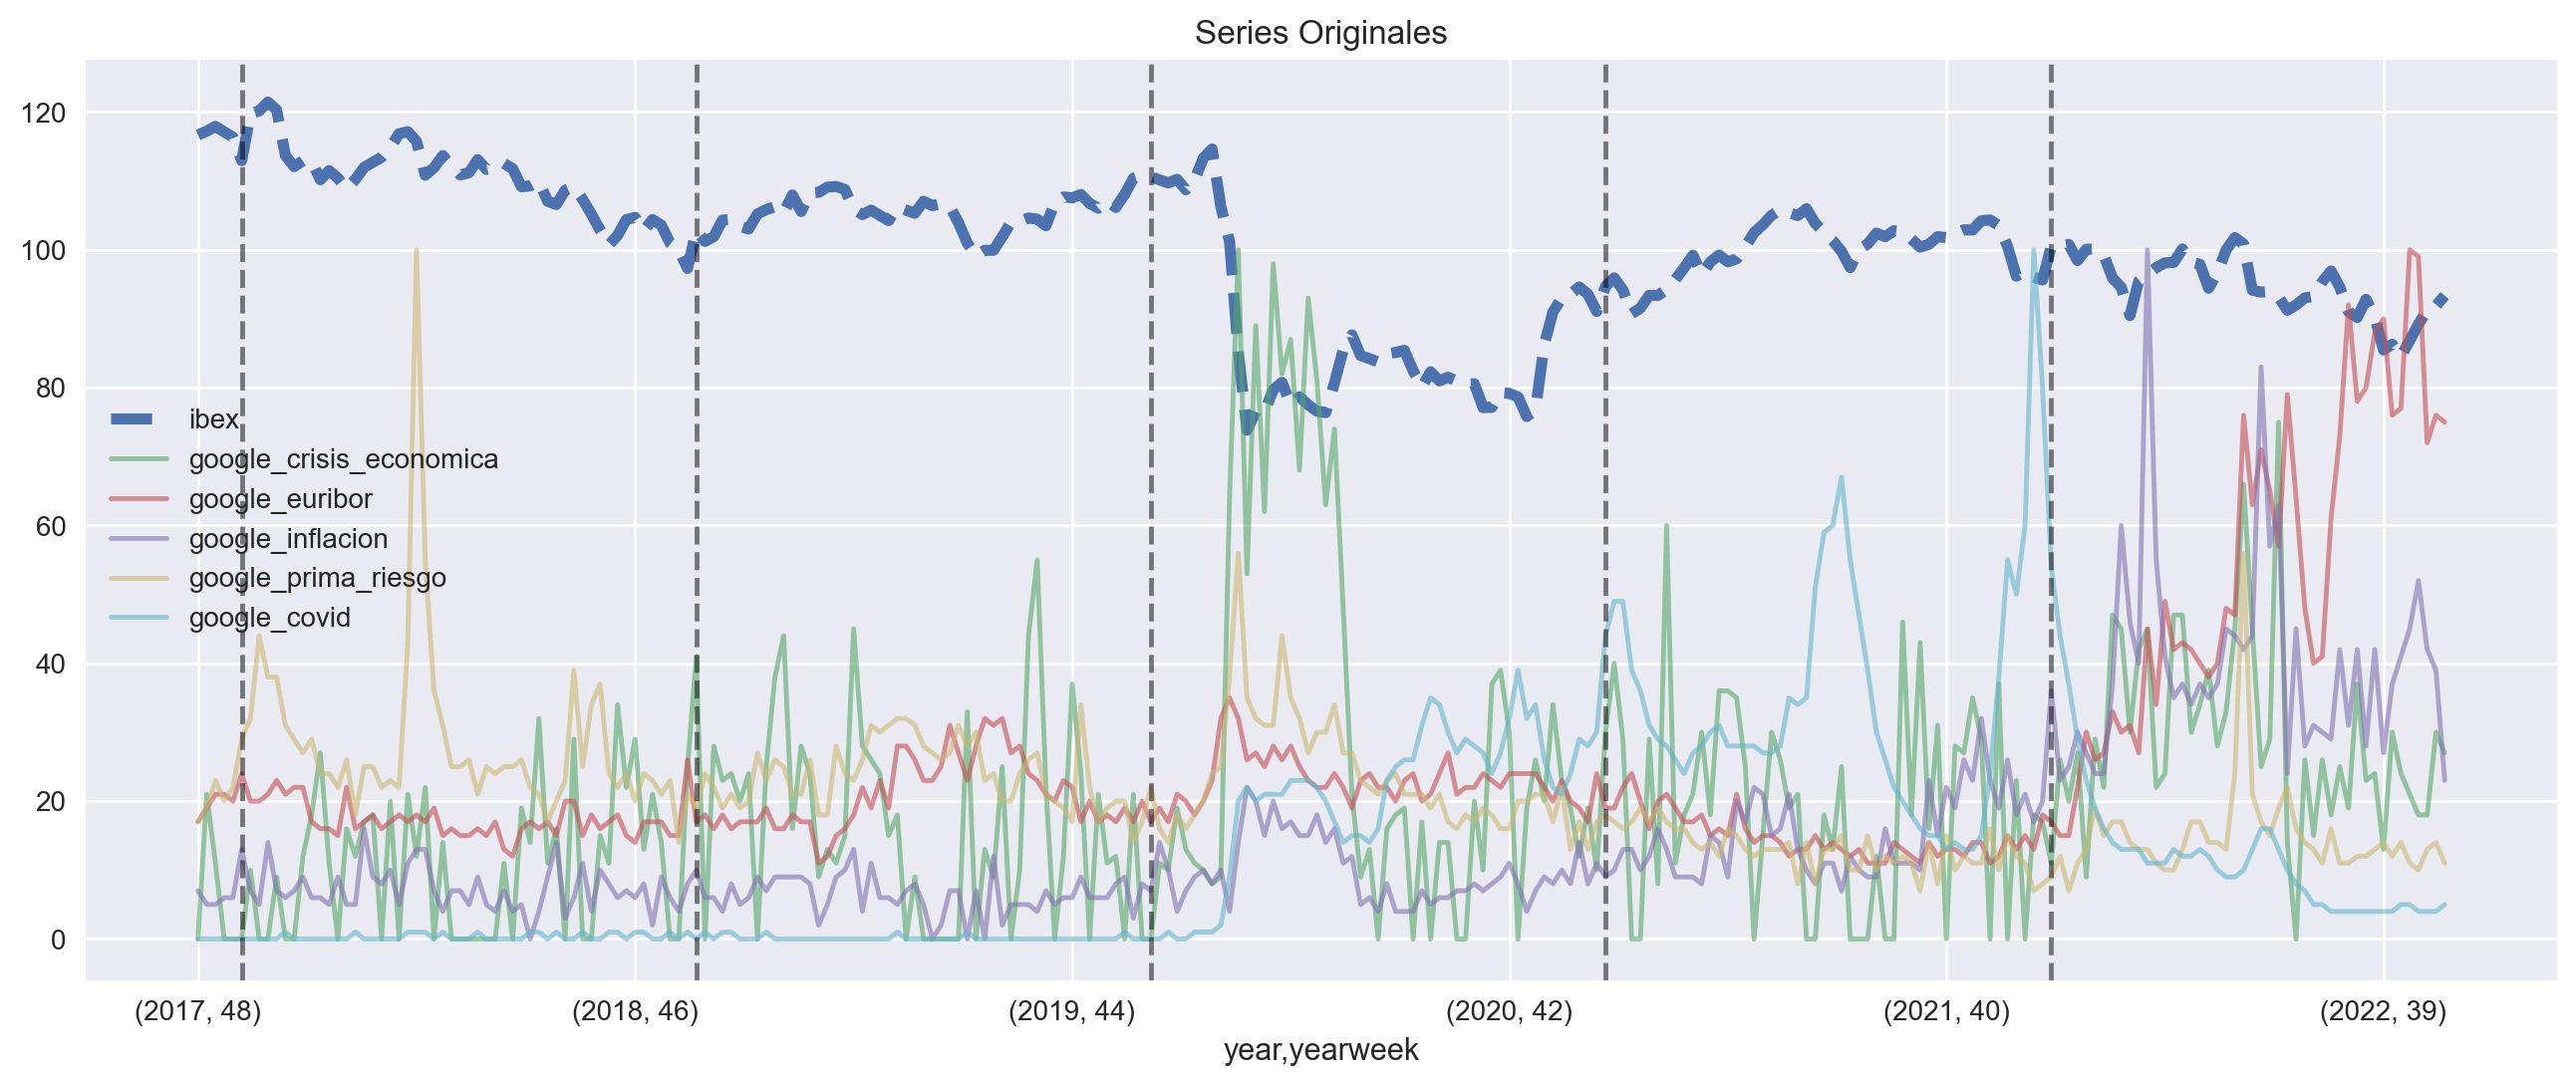

In [5]:
fig, ax = plt.subplots()

df_plot = (df
    .assign(ibex=df["ibex"].div(df["ibex"].mean()).mul(100))
)

plot_series(df_plot, ax=ax, title="Series Originales")

## Tratamiento de las series temporales 

### Normalizacion

Para asegurarnos de que todas las series estén en la misma escala
$$
y^{\text{norm}}_t = \frac{y_t - \mu}{\sigma}
$$
donde $\mu$ y $\sigma$ son la media y desviación típica correspondiente a cada serie. 

In [6]:
ss = StandardScaler()
ss.fit(df)
def normalize(df, ss):
    X = ss.transform(df)
    df = pd.DataFrame(X, columns=df.columns, index=df.index)
    return df

def normalize_inv(df, ss):
    X = ss.inverse_transform(df)
    df = pd.DataFrame(X, columns=df.columns, index=df.index)
    return df

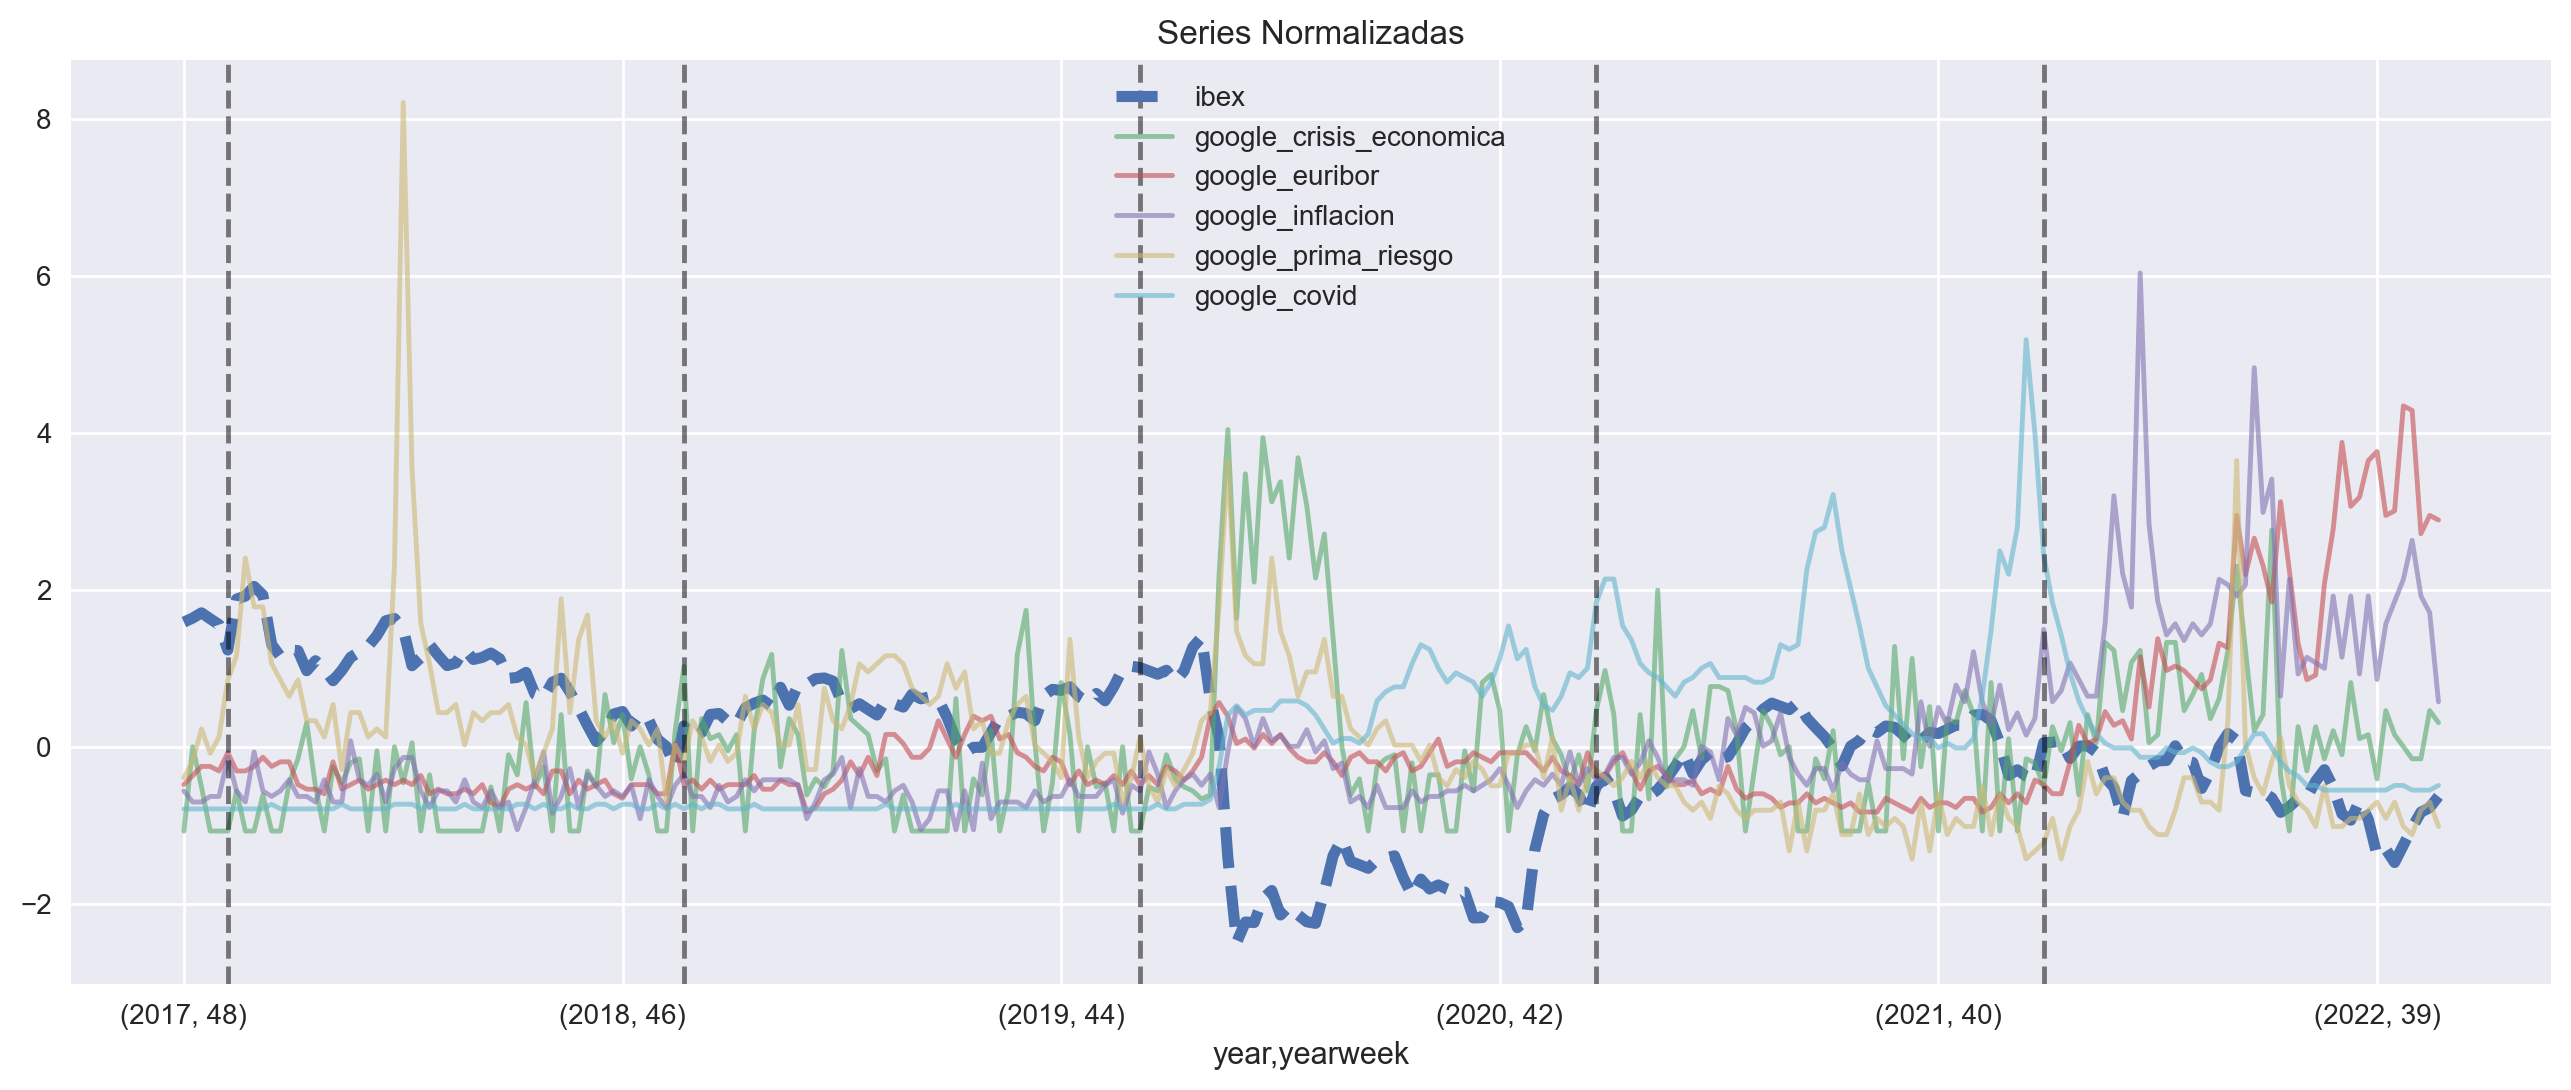

In [7]:
df_norm = normalize(df, ss)

fig, ax = plt.subplots()
plot_series(df_norm, ax=ax, title="Series Normalizadas")

### Tomar primeras diferencias

Tomamos las primeras diferencias para **borrar las tendencias** en las series. Si $y_t$ es la observación en el tiempo $t$ de nuestra serie, la primera diferencia se define como 
$$
d^1_t = y_t - y_{t-1}
$$

In [8]:
def first_diff(df):
    return df.diff().dropna()

def first_diff_inv(df, initial_values):
    df = pd.concat([
        pd.DataFrame(
            initial_values.reshape((1, df.shape[1])), 
            columns=df.columns, 
            index=pd.MultiIndex.from_tuples(
                [df.index[0]], 
                names=df.index.names
            )
        ), 
        df.cumsum().add(initial_values)], 
        axis=0
    )
    return df

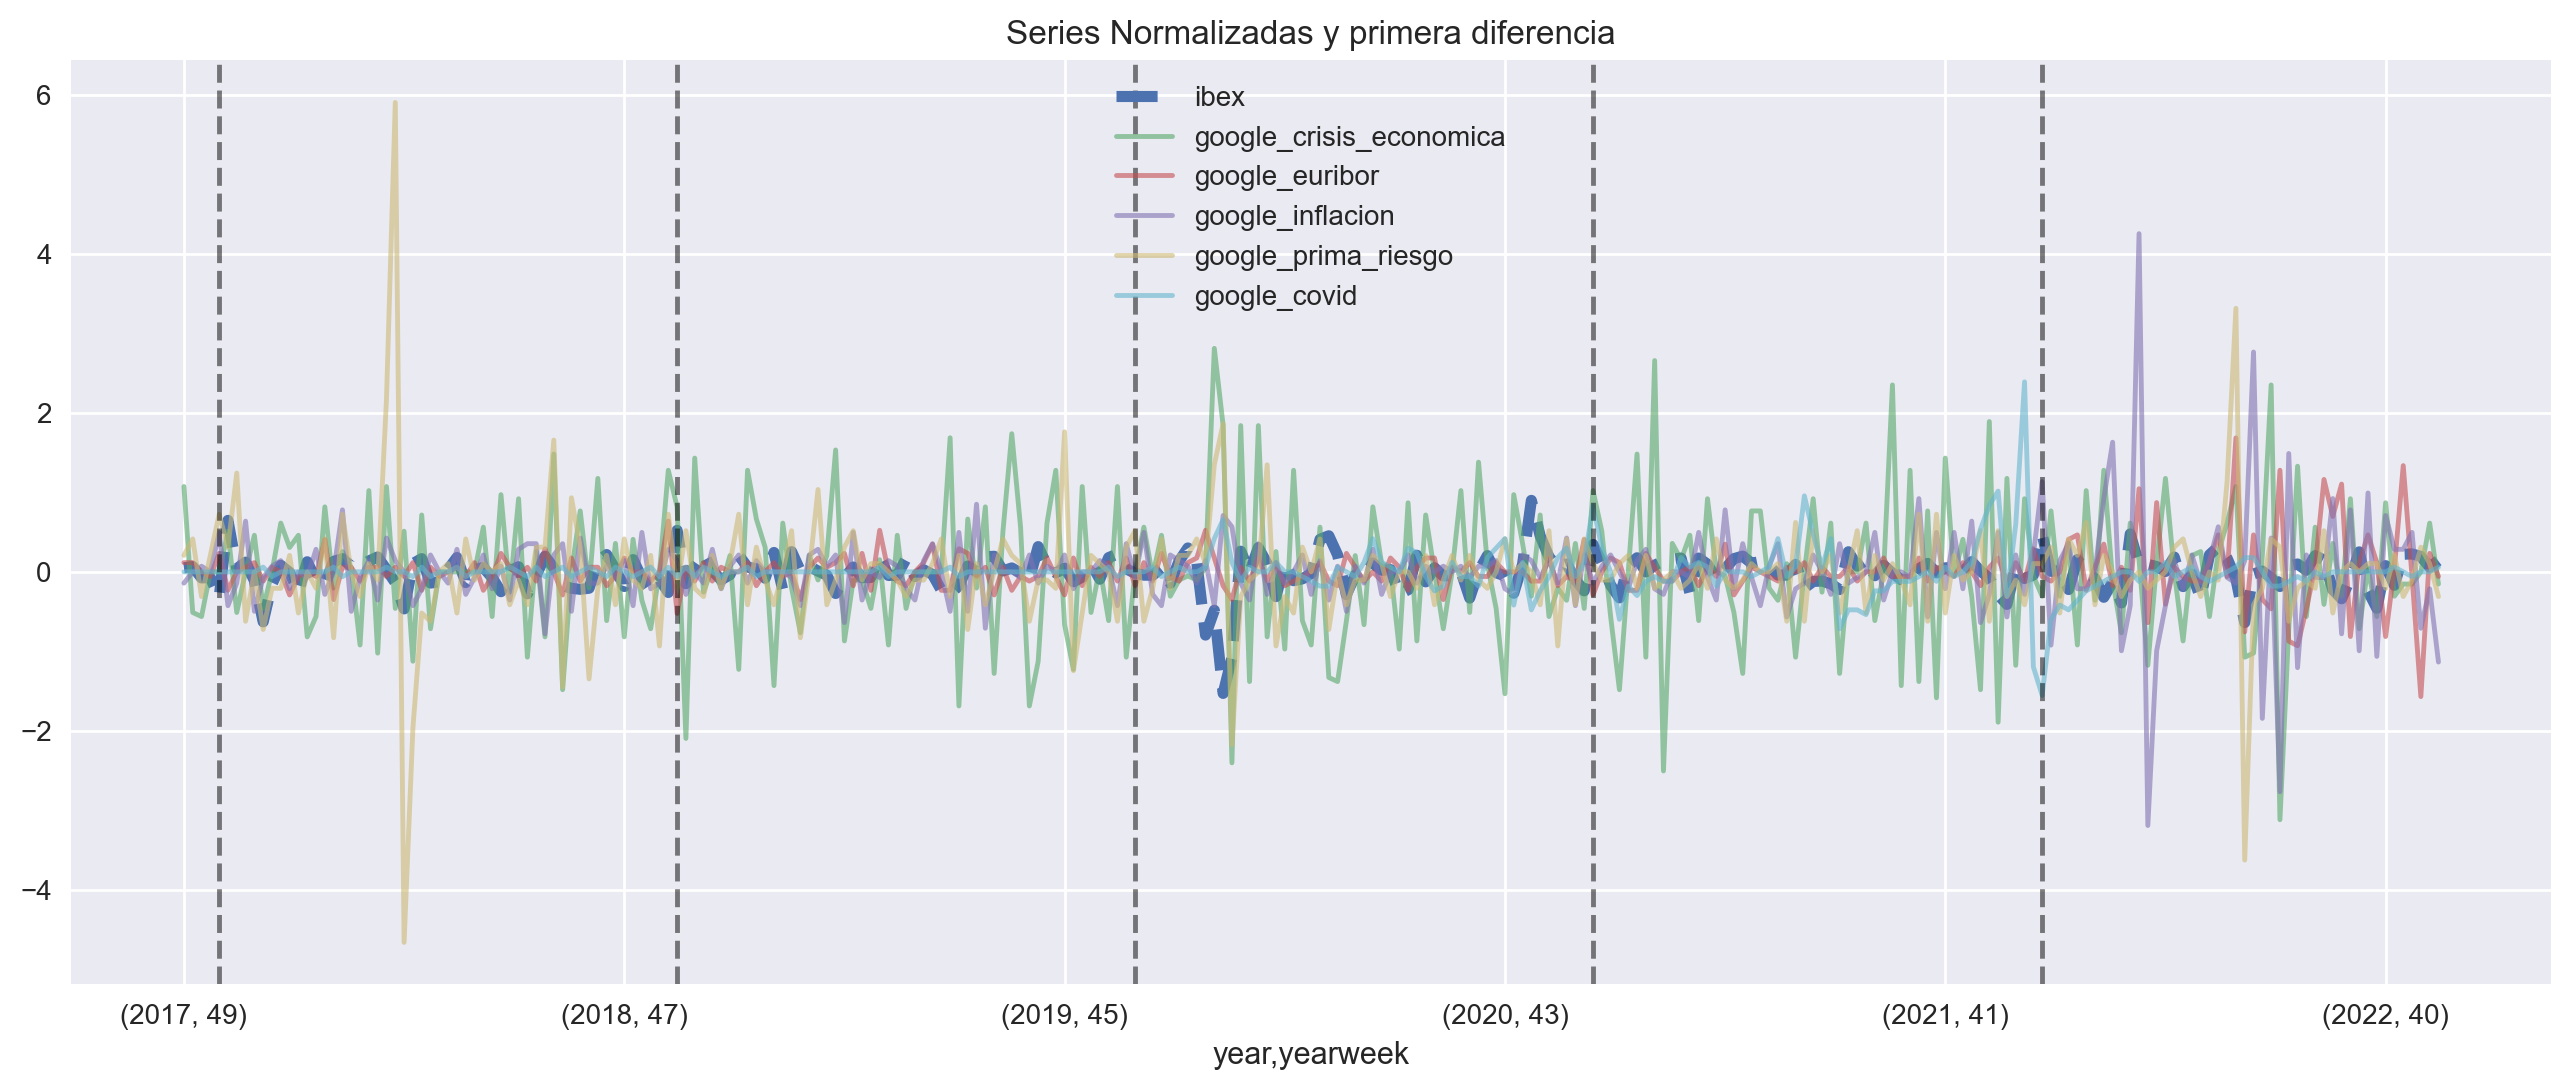

In [9]:
df_diff = first_diff(df_norm)

fig, ax = plt.subplots()
plot_series(df_diff, ax=ax, title="Series Normalizadas y primera diferencia")

Hagamos zoom por ejemplo en 2020

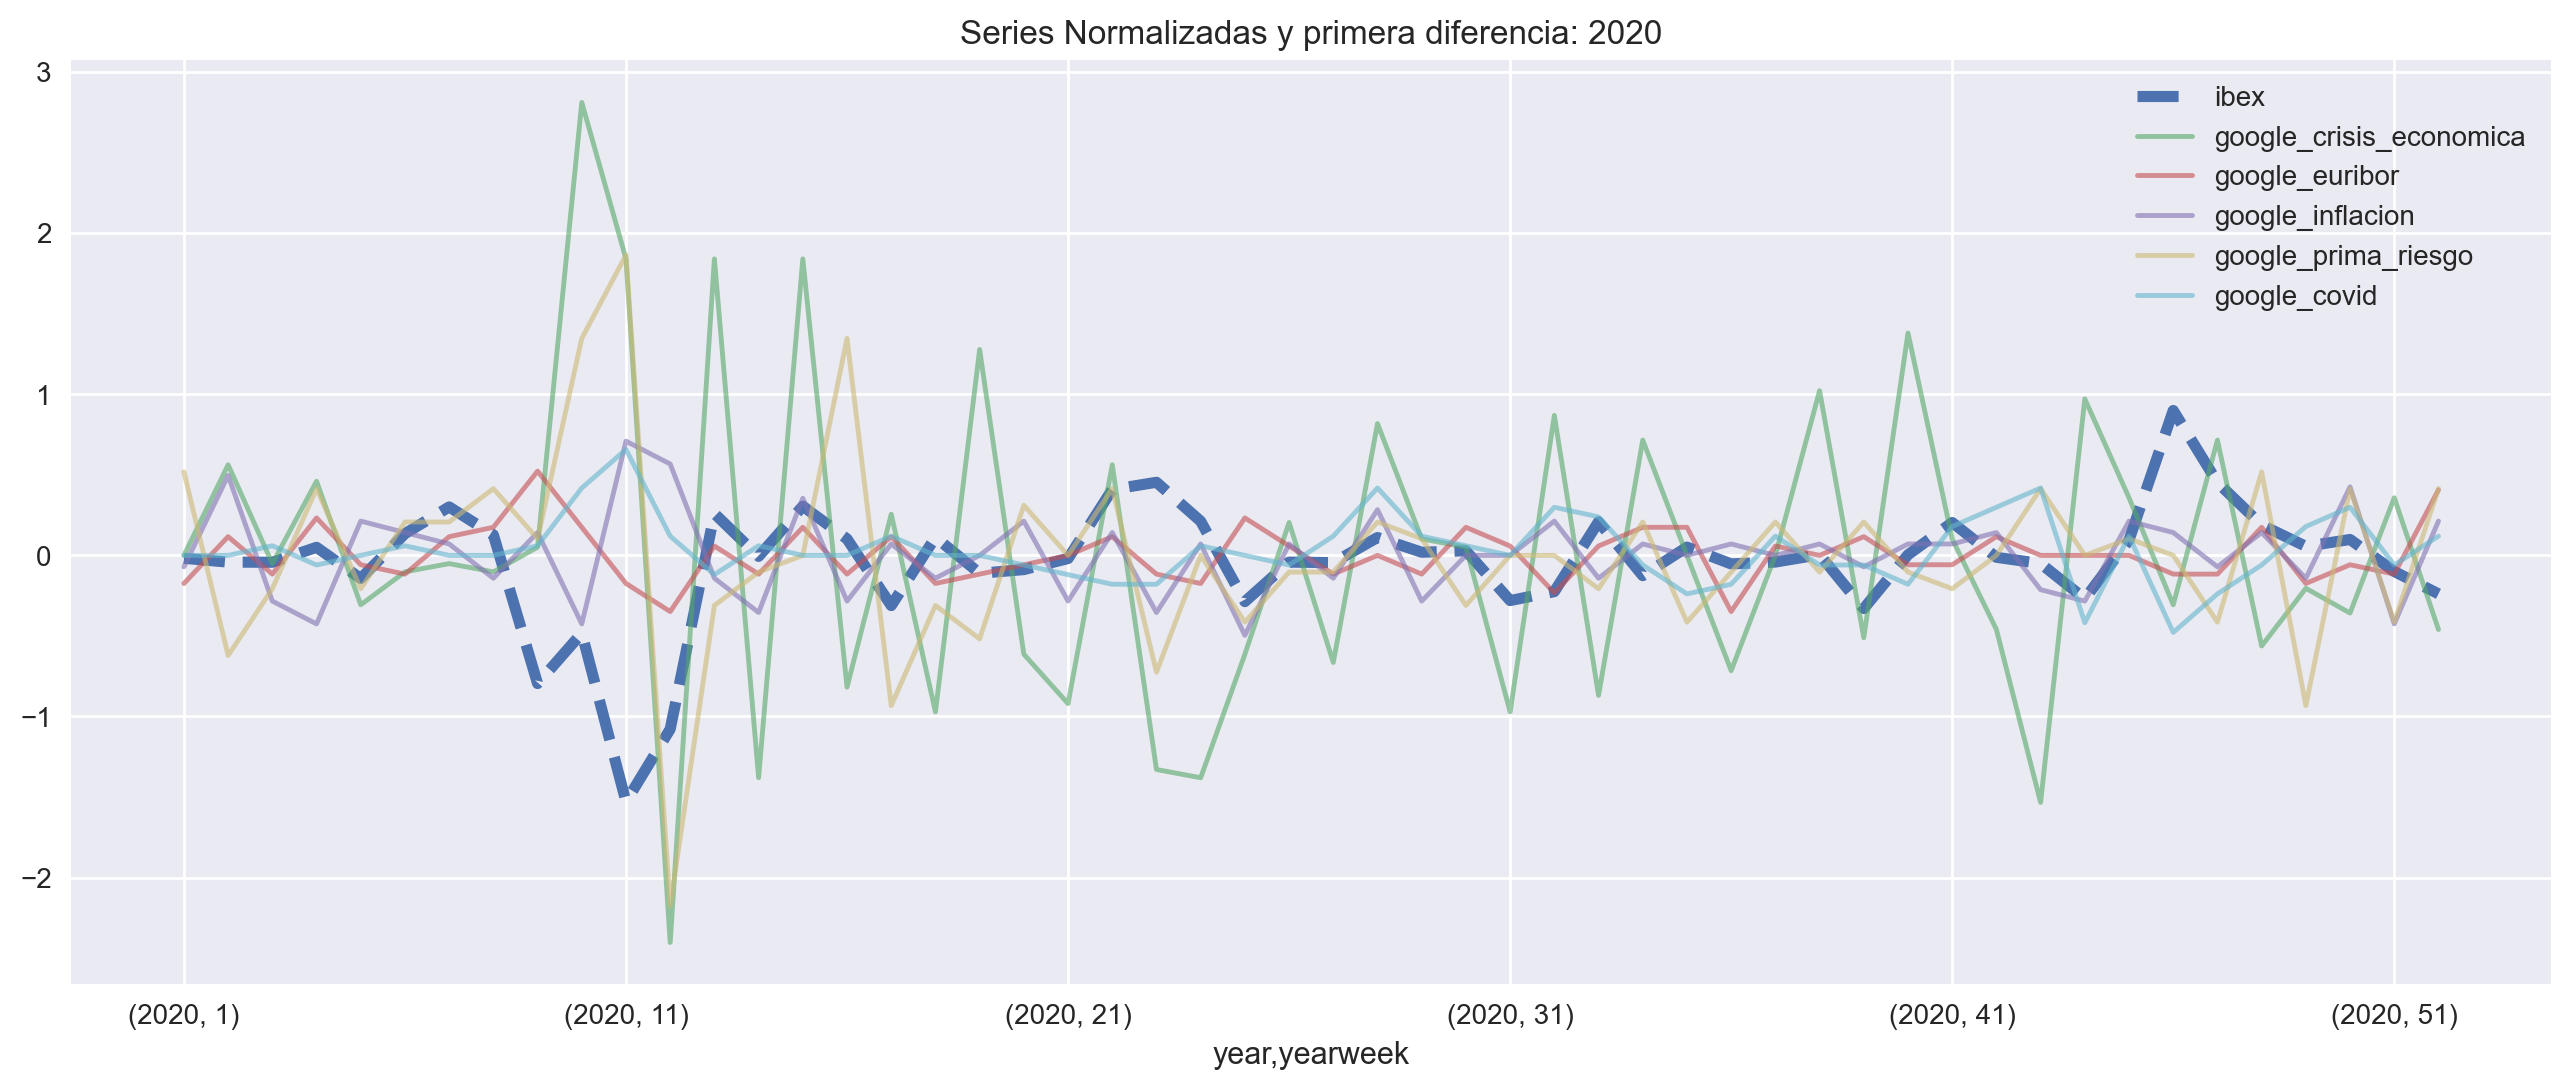

In [10]:
fig, ax = plt.subplots()
mask = df_diff.index.get_level_values("year") == 2020
plot_series(df_diff[mask], ax=ax, title="Series Normalizadas y primera diferencia: 2020")

Observemos que el aumento de búsquedas de *crisis económica* en google cerca de la semana 10 de 2020 (principios de la pandemia) va precedido de un decaemiento en el índice Ibex35

### Borramos incremento de la volatilidad 

Ciertas series sufren aumentos repentinos en su volatilidad. Vamos a calcular las desviaciones estándar del año y dividir por dichos valores. 

In [11]:
def _remove_volatility(col):
    f = lambda _df: np.select([_df[col + "_av"] == 0], [0], _df[col] / _df[col + "_av"])
    return f

def remove_volatility(df):
    annual_volatility = df.groupby("year").std()
    df_av = pd.merge(
        df, 
        annual_volatility, 
        left_on="year", 
        right_index=True, 
        suffixes=("", "_av")
    )
    df_av = df_av.assign(
        **{col:_remove_volatility(col) for col in df.columns}
    )
    df = df_av.drop(columns=[col for col in df_av.columns if col.endswith("_av")])
    return df

### Estacionalidad

Podemos borrar la estacionalidad de una serie restando la media observada lo largo de un cuatrimestre o un mes.

In [12]:
def _remove_seasonality(col):
    f = lambda _df: _df[col] - _df[col + "_month_average"]
    return f
def remove_seasonality(df):
    df["month"] = df.index.get_level_values(1)
    df["month"] = df["month"].floordiv(4).mod(12).add(1)
    month_average = df.groupby("month").mean()

    df_ma = pd.merge(
        df, 
        month_average, 
        left_on="month", 
        right_index=True, 
        suffixes=("", "_month_average")
    )
    df_ma = df_ma.drop("month", axis=1)
    df = df.drop("month", axis=1)
    df_ma = df_ma.assign(
        **{col:_remove_seasonality(col) for col in df.columns}
    )
    df = df_ma.drop(columns=[col for col in df_ma.columns if col.endswith("_month_average")])
    return df

## Pipeline completo

Tras combinar varias de estas transformaciones vamos a quedarnos con la siguiente transformación
1. Normalizar 
2. Quitar diferencias

In [13]:
def pipeline(df):
    df = normalize(df, ss)
    df = first_diff(df)
    return df

def pipeline_inv(df, initial_values):
    df = first_diff_inv(df, initial_values)
    df = normalize_inv(df, ss)
    return df

In [14]:
df_trans = pipeline(df)

## Correlaciones

Estudiamos las posibles autocorrelaciones (correlación entre la serie objetivo y sus lageados)

/var/folders/0d/bjgxnx654svf3nsy9chj63rh0000gn/T/ipykernel_43446/3865749966.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


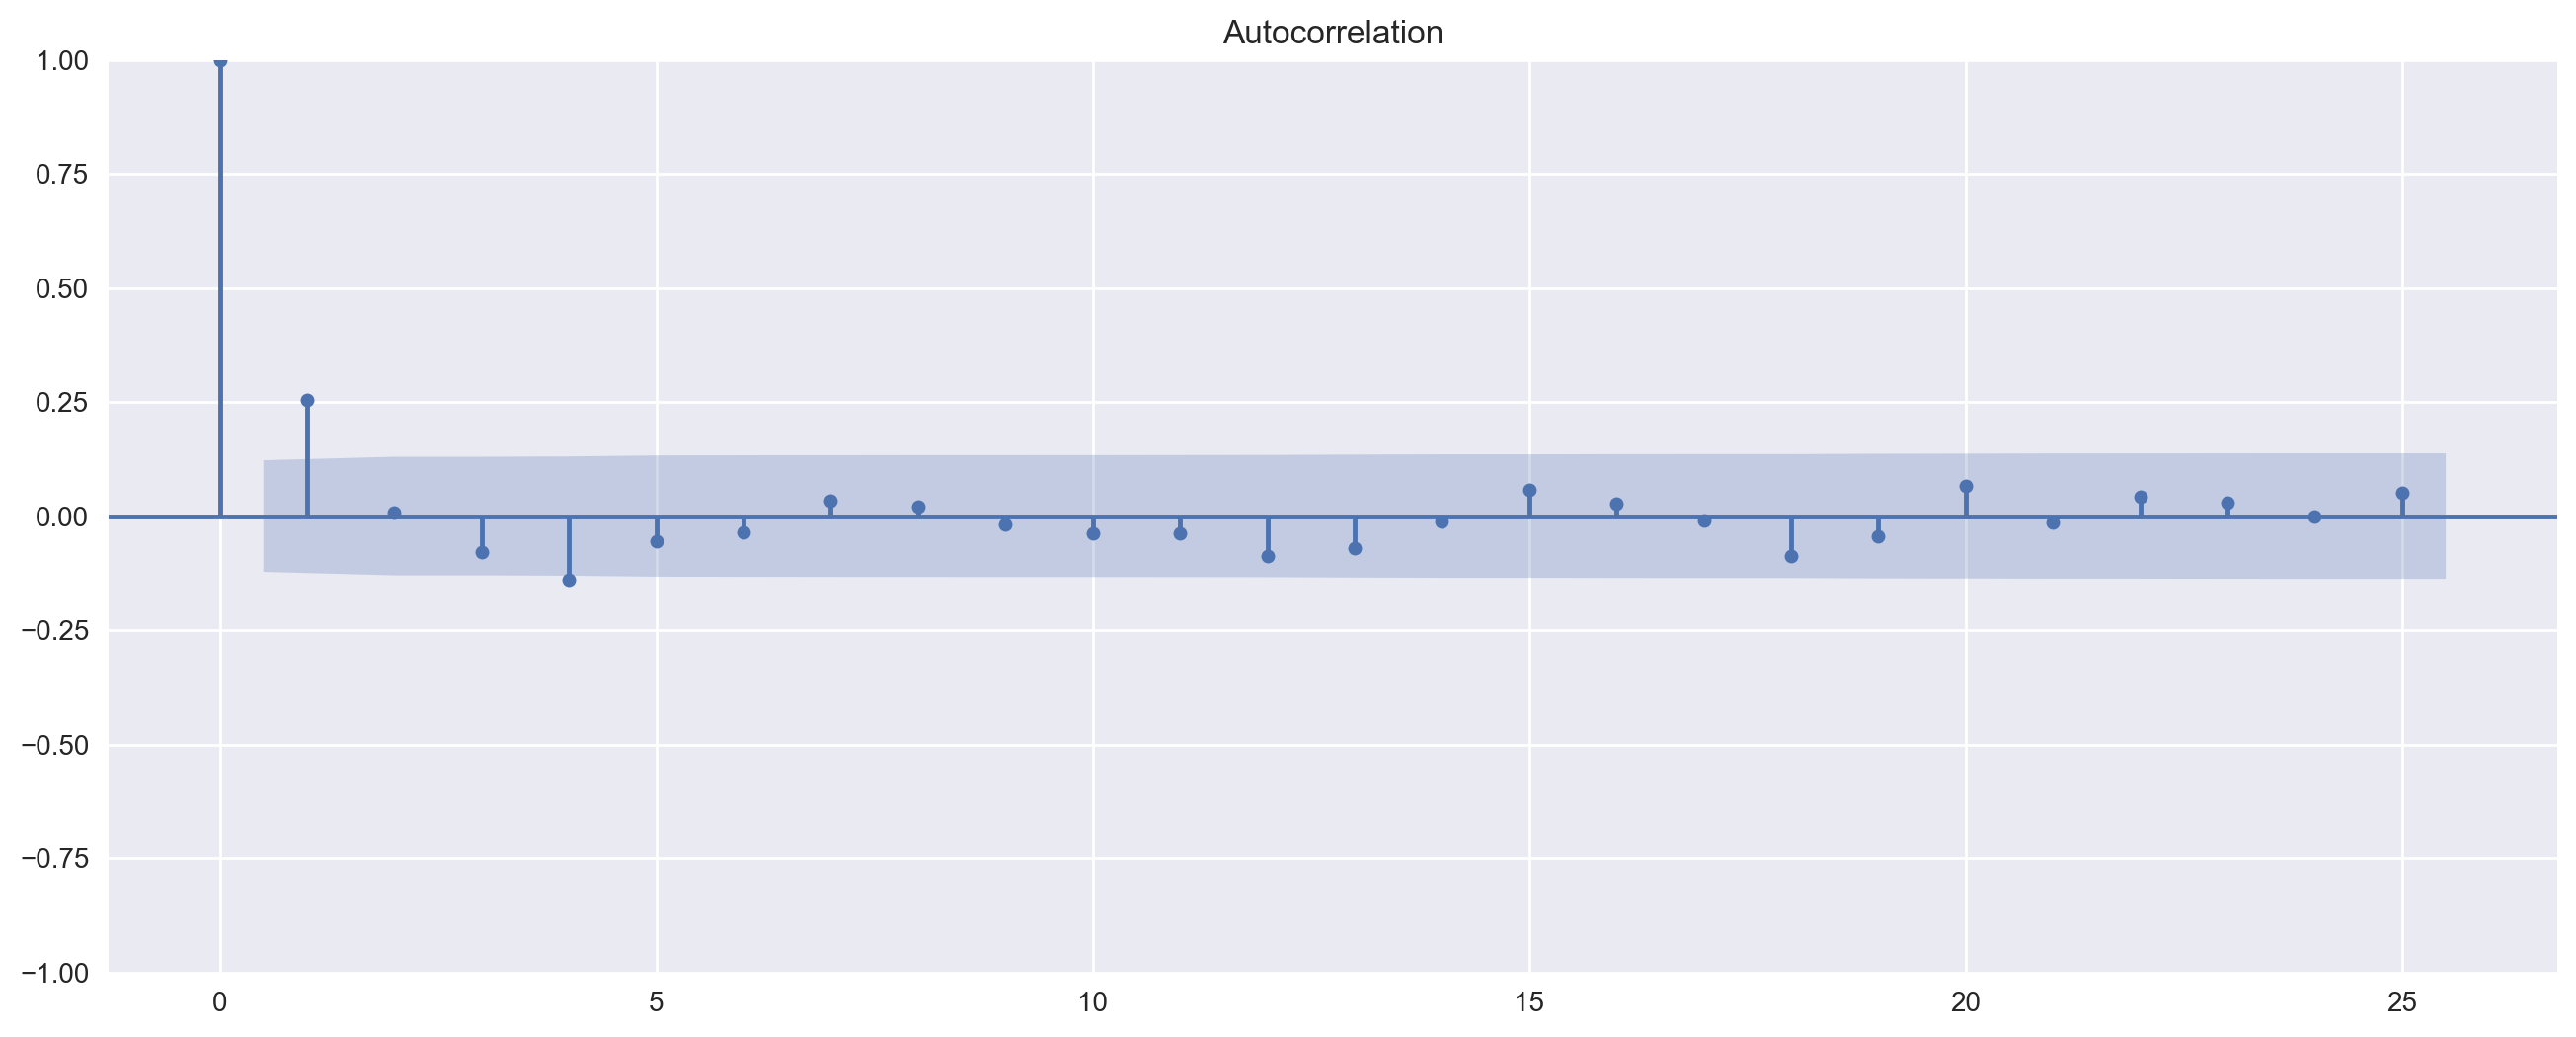

In [15]:
fig, ax = plt.subplots()
plot_acf(df_trans["ibex"], ax=ax)

fig.show()

Vemos que es destacable **primer valor lageado**. Recordemos que estamos trabajando ya con la primera derivada de la serie (primera diferencia). Luego lo que estamos viendo es que la diferencia entre un día y otro puede estar correlacionada con la diferencia del día siguiente. 

Estudiamos ahora la correlación de `ibex` con el resto de componentes. 

In [16]:
from itertools import product

lag_max = 15

cols = [col for col in df_trans.columns if col.startswith("google")]
corrs = {comp:list() for comp in cols}
for comp, lag in product(cols, range(1, lag_max)):
    ibex_series = df_trans["ibex"].iloc[lag:]
    lagged_comp_series = df_trans[comp].iloc[:-lag]
    r_pearson = pearsonr(ibex_series, lagged_comp_series)
    corrs[comp].append(r_pearson[1]) # nos quedamos con el p-valor

In [17]:
df_corrs = pd.DataFrame(corrs, index=pd.Series(range(1, lag_max), name="lag"))

In [18]:
df_corrs

,google_crisis_economica,google_euribor,google_inflacion,google_prima_riesgo,google_covid
lag,,,,,
1,0.032074,0.221810,0.852060,0.000137,0.000232
2,0.102025,0.186883,0.620070,0.104714,0.312940
3,0.384650,0.100550,0.715323,0.961431,0.934782
4,0.417500,0.938224,0.175432,0.979256,0.512974
5,0.377093,0.634057,0.481482,0.295830,0.375444
6,0.832541,0.963927,0.915957,0.973699,0.431050
7,0.646177,0.765814,0.423991,0.142620,0.366362
8,0.859275,0.382403,0.236399,0.488021,0.467673
9,0.559821,0.126780,0.772131,0.995174,0.491052


Text(0.5, 1.0, 'P valor de los coeficientes de correlación')

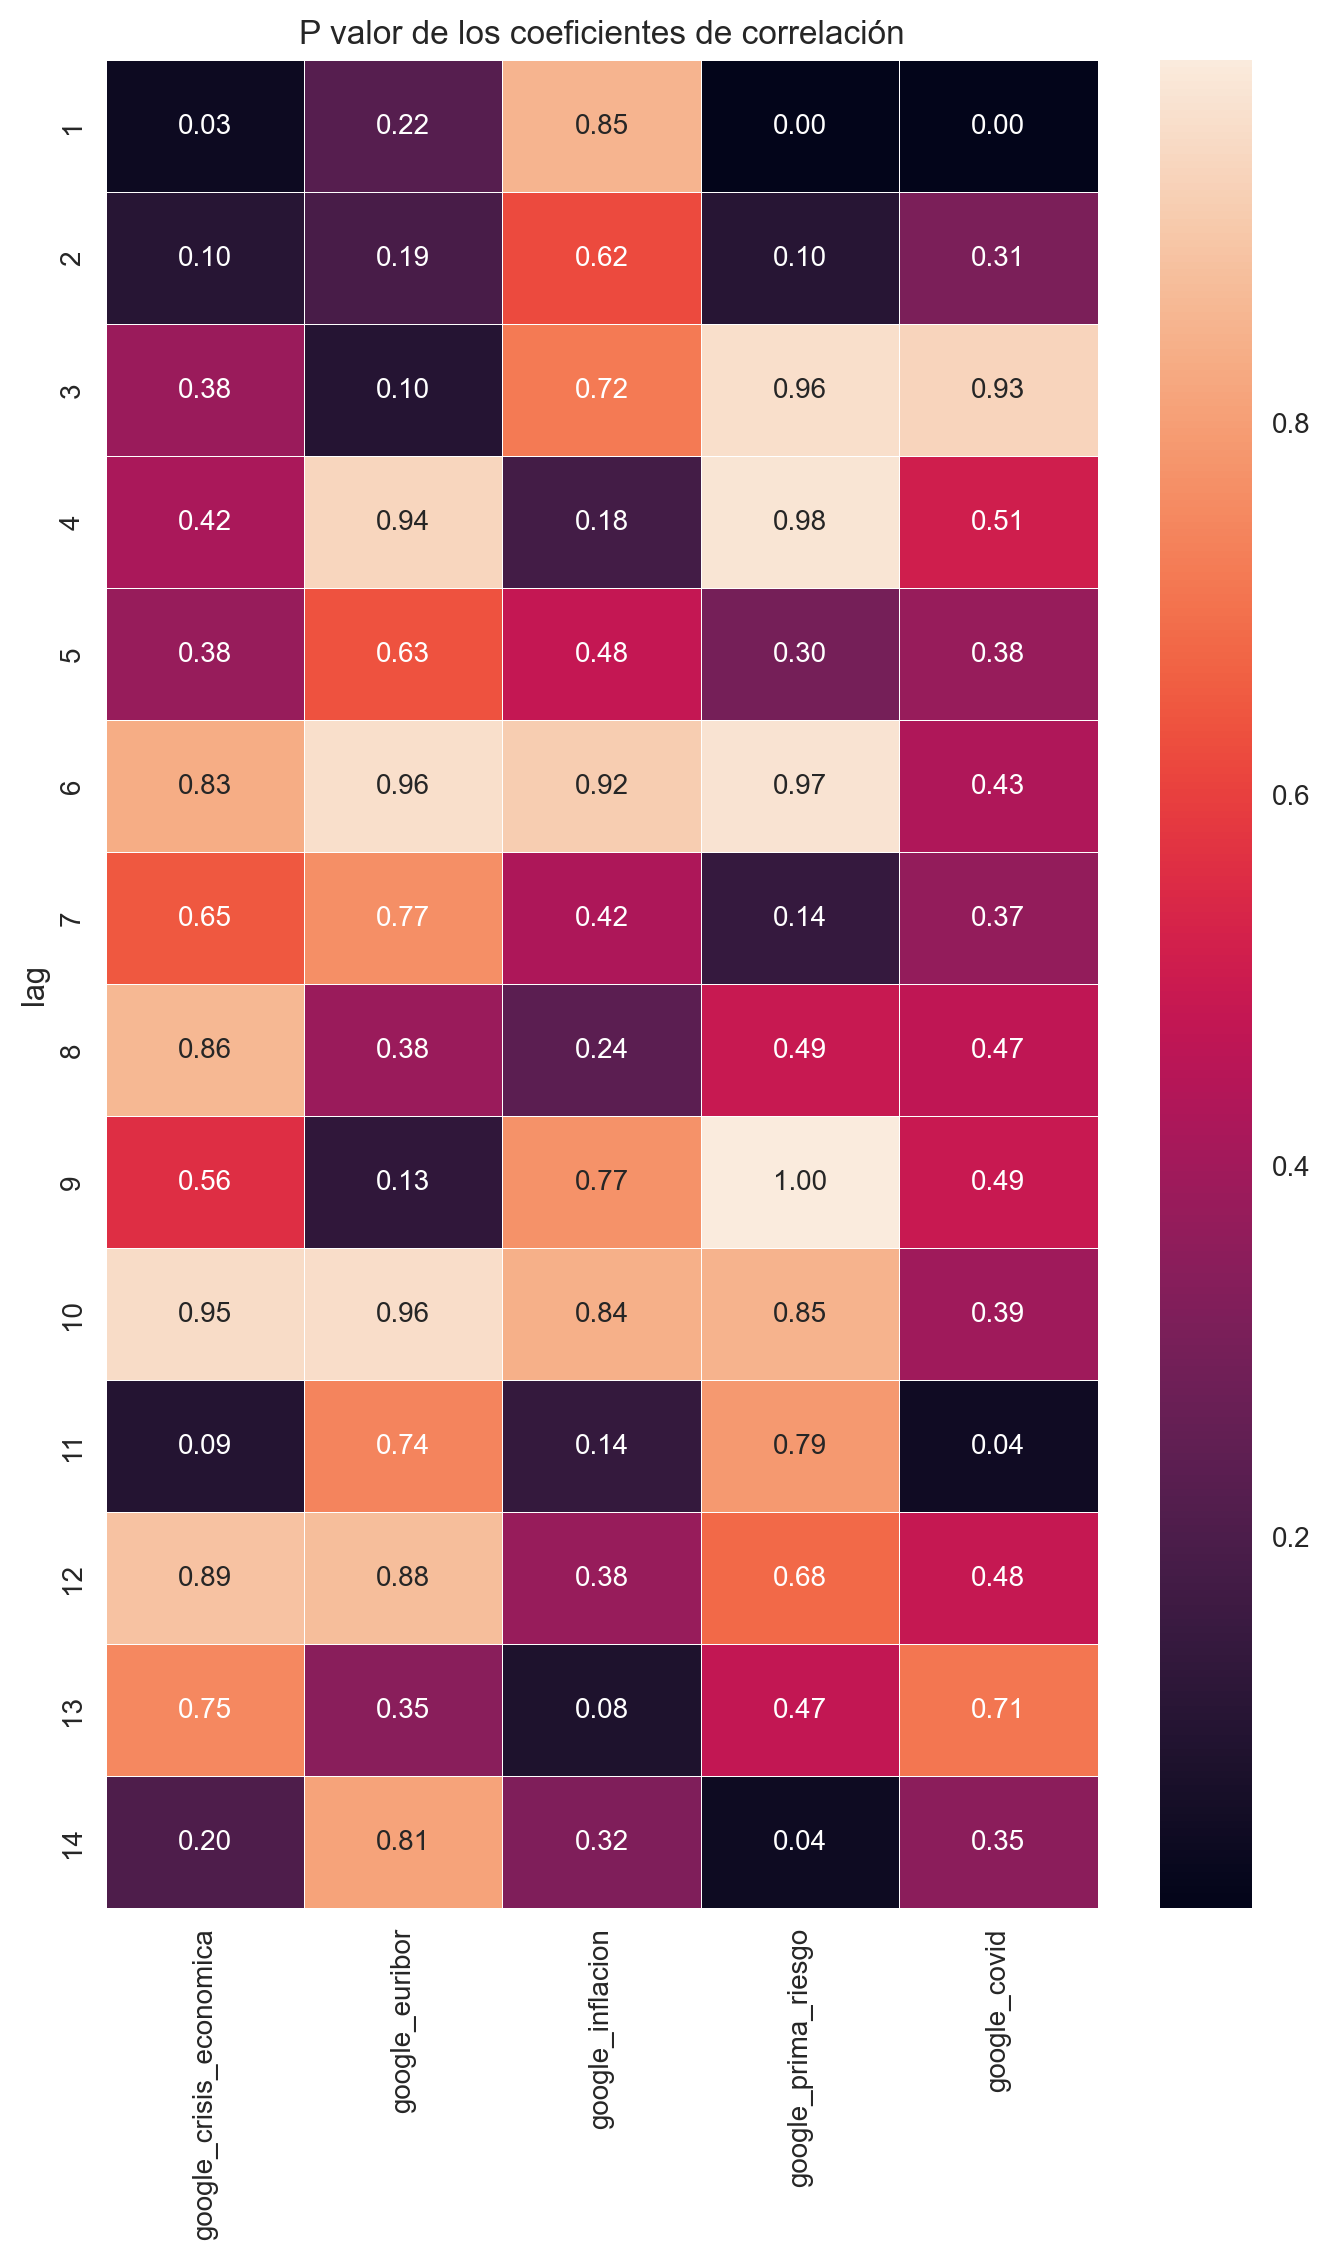

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))

sns.heatmap(df_corrs, annot=True, ax=ax, linewidths=0.2, fmt=".2f")
ax.set_title("P valor de los coeficientes de correlación")

## Modelado 

Vamos a utilizar un modelo de Autoregresión Vectorizada (VAR) para modelizar esta serie temporal vectorizada. Recordemos que nuestra variable objetivo es `ibex`.

In [20]:
model = VAR(df_trans)

/Users/javlintor/entrevista_camgemini/dev/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
maxlags = 15
results = model.fit(maxlags=maxlags)

Vamos a explorar los parámetros que el modelo ha considerado más estadísticamente fiables

In [22]:
results.params["ibex"][results.pvalues["ibex"] < 0.05]

L1.ibex                       0.229396
L1.google_crisis_economica   -0.043072
L1.google_inflacion           0.131506
L1.google_prima_riesgo       -0.086455
L1.google_covid              -0.241495
L2.google_crisis_economica   -0.049911
L2.google_euribor            -0.132395
L3.google_euribor            -0.150125
L5.google_prima_riesgo       -0.062223
L9.google_covid              -0.130879
L14.google_covid             -0.242193
Name: ibex, dtype: float64

## Forecast

In [23]:
def compute_index(initial_year, initial_week, steps):
    return [(initial_year + ((initial_week + n) // 52), (initial_week + n) % 52 + 1) for n in range(steps)]
    
def forecast(df, steps): 
    X_pred = results.forecast(df.values[-maxlags:], 100)
    index = pd.MultiIndex.from_tuples(
        compute_index(df.index[-1][0], df.index[-1][1], steps), 
        names=df.index.names
    )
    df_pred = pd.DataFrame(X_pred, columns=df.columns, index=index)
    return df_pred

In [24]:
df_trans_pred = forecast(df_trans, 100)

In [25]:
df_pred = pipeline_inv(df_trans_pred, initial_values=df_trans.iloc[-1, :].values)

In [26]:
df_pred

ibex  google_crisis_economica  google_euribor  \
year yearweek                                                         
2022 47        8843.360084                18.003876       24.310078   
     47        8974.129951                26.501849       51.342490   
     48        8516.704060                11.451363       44.544571   
     49        8187.869445                32.542885       48.723034   
     50        8038.029759                 5.139694       33.968382   
...                    ...                      ...             ...   
2024 38        6849.250529                43.339305       89.091834   
     39        6840.918985                44.865267       90.866245   
     40        6843.498164                39.724373       92.669805   
     41        6853.488502                40.918372       90.755847   
     42        6831.132985                42.149288       89.978093   

               google_inflacion  google_prima_riesgo  google_covid  
year yearweek                                                       
2022 47               -1.069767            17.806202     14.251938  
     47                9.865770            21.250304     11.688593  
     48               11.280688            16.191892     10.839771  
     49               15.181597            17.198651     17.239373  
     50               13.065339            14.508462     20.513026  
...                         ...                  ...           ...  
2024 38               25.322065            18.290493      3.969275  
     39               27.961315            19.252923      4.660901  
     40               28.996215            19.150423      5.249935  
     41               34.450620            19.278726      5.472448  
     42               31.531781            19.053564      5.078244  

[101 rows x 6 columns]

In [27]:
df_all = pd.concat([df, df_pred], axis=0)

Text(0.5, 1.0, 'Forecast para ibex35')

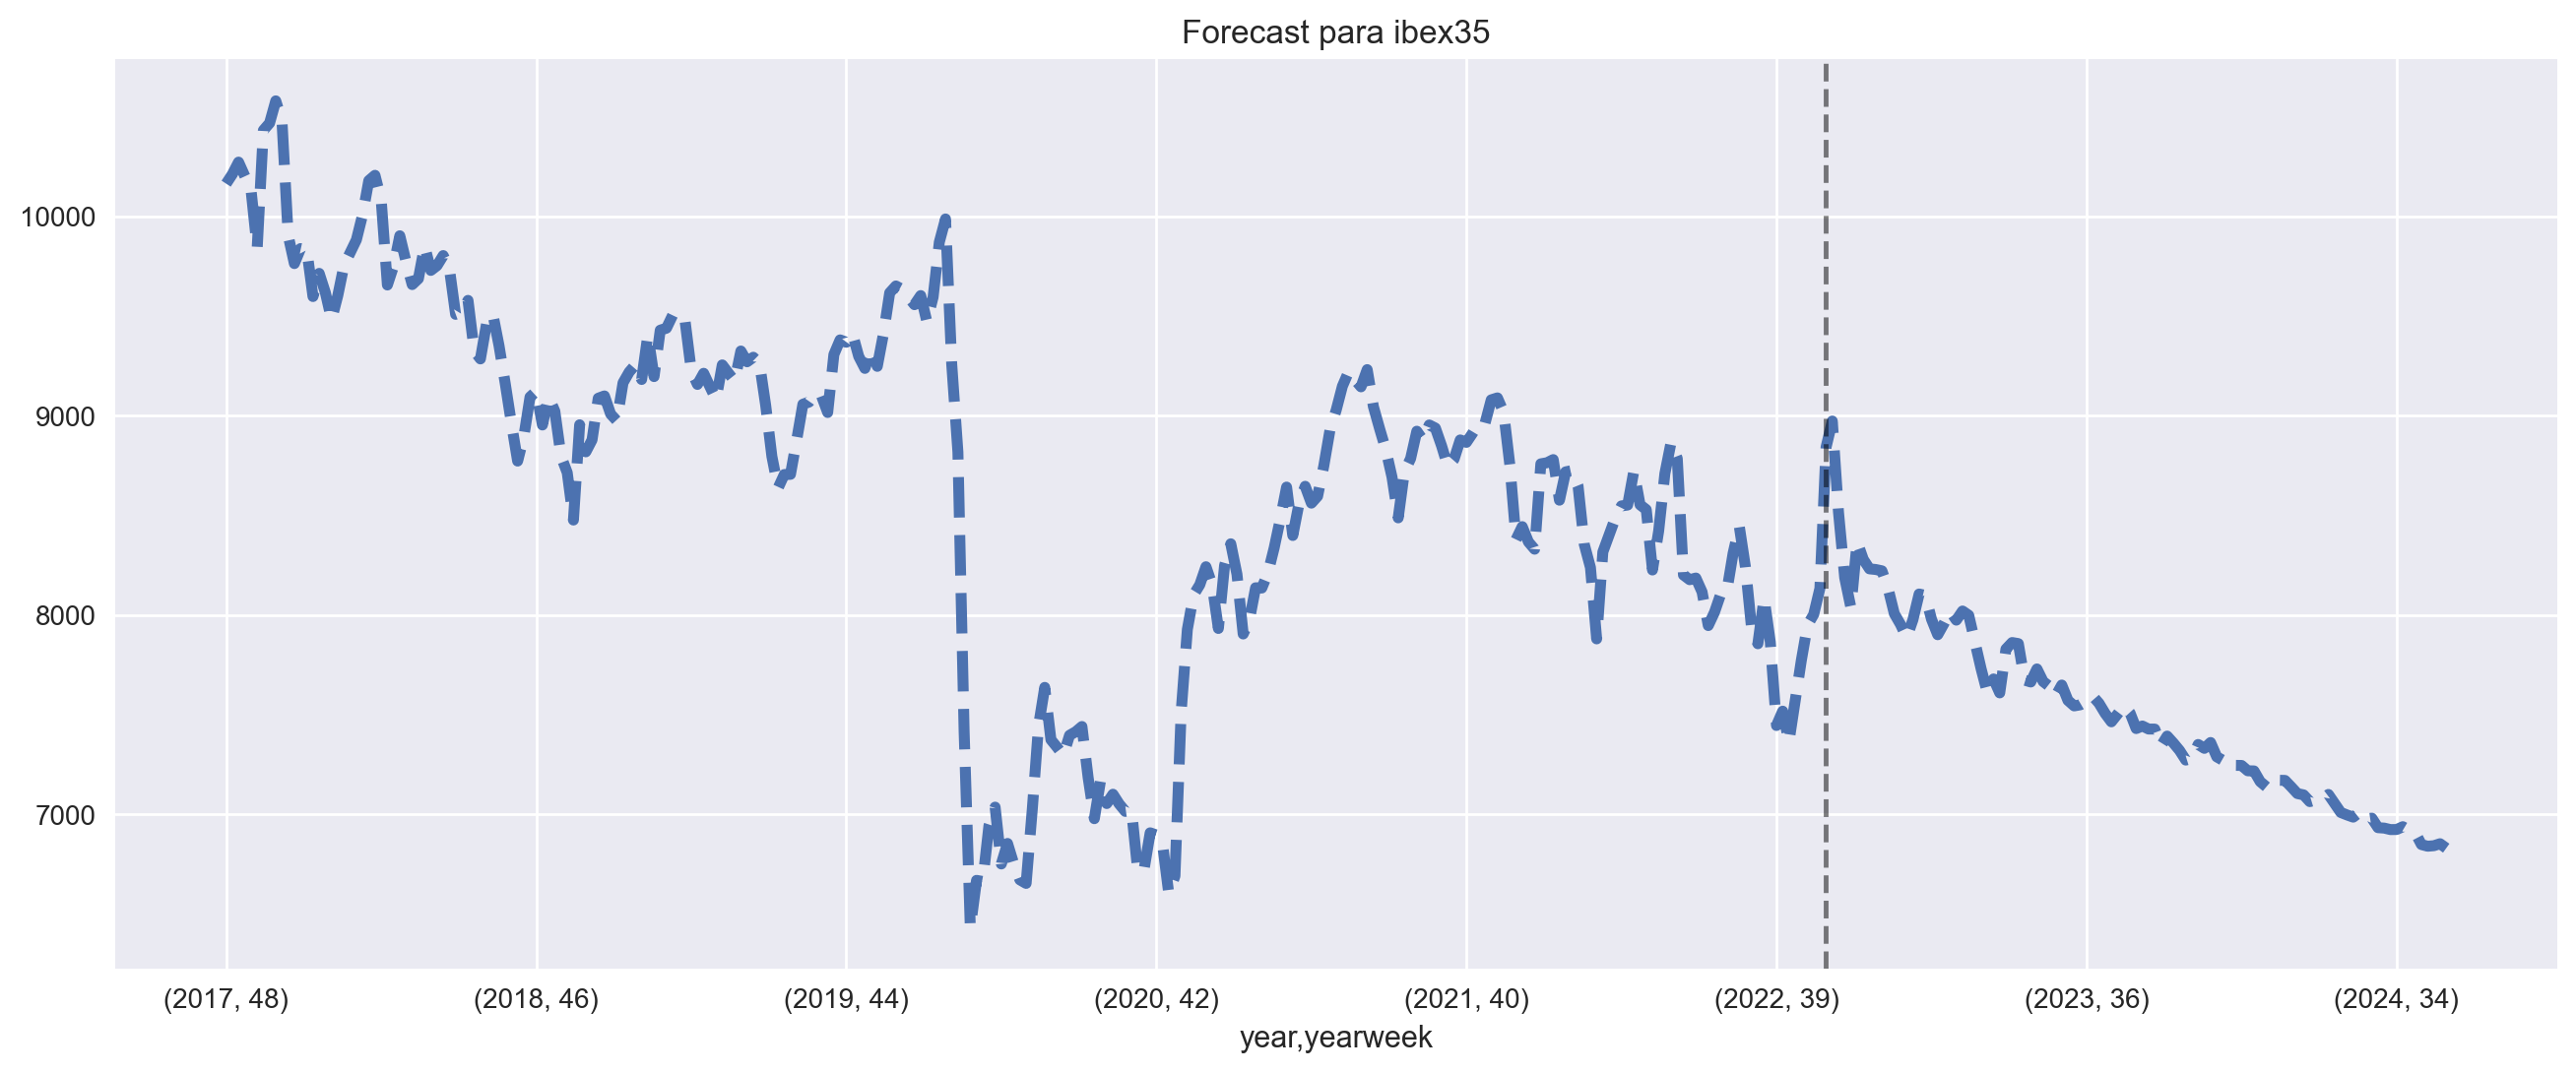

In [28]:
fig, ax = plt.subplots()

# Funciones auxiliares para pintar series
df_all["ibex"].plot(ax=ax, linewidth=4, linestyle="dashed", label="ibex")
ax.axvline(np.argmax(df_all.index >= df_pred.index[0]), linestyle='--', color='k', alpha=0.5)
ax.set_title("Forecast para ibex35")